In [1]:
import os, sys
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent))

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import pickle

from runner import Runner
%load_ext autoreload
%autoreload 2

In [2]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_dataset = datasets.MNIST(root="../data", train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

In [3]:
runners = [
    {
        "runner": Runner.load("../runner_no_class_no_steer.pkl"),
        "cmap": "Greens_r", 
        "title": "Vanilla VAE",
    },
    {
        "runner": Runner.load("../runner_class_no_steer.pkl"),
        "cmap": "Blues_r", 
        "title": "Class-conditioned VAE",
    },
    {
        "runner": Runner.load("../runner_class_steer.pkl"),
        "cmap": "Purples_r", 
        "title": "Steerable Class-conditioned VAE",
    },
]

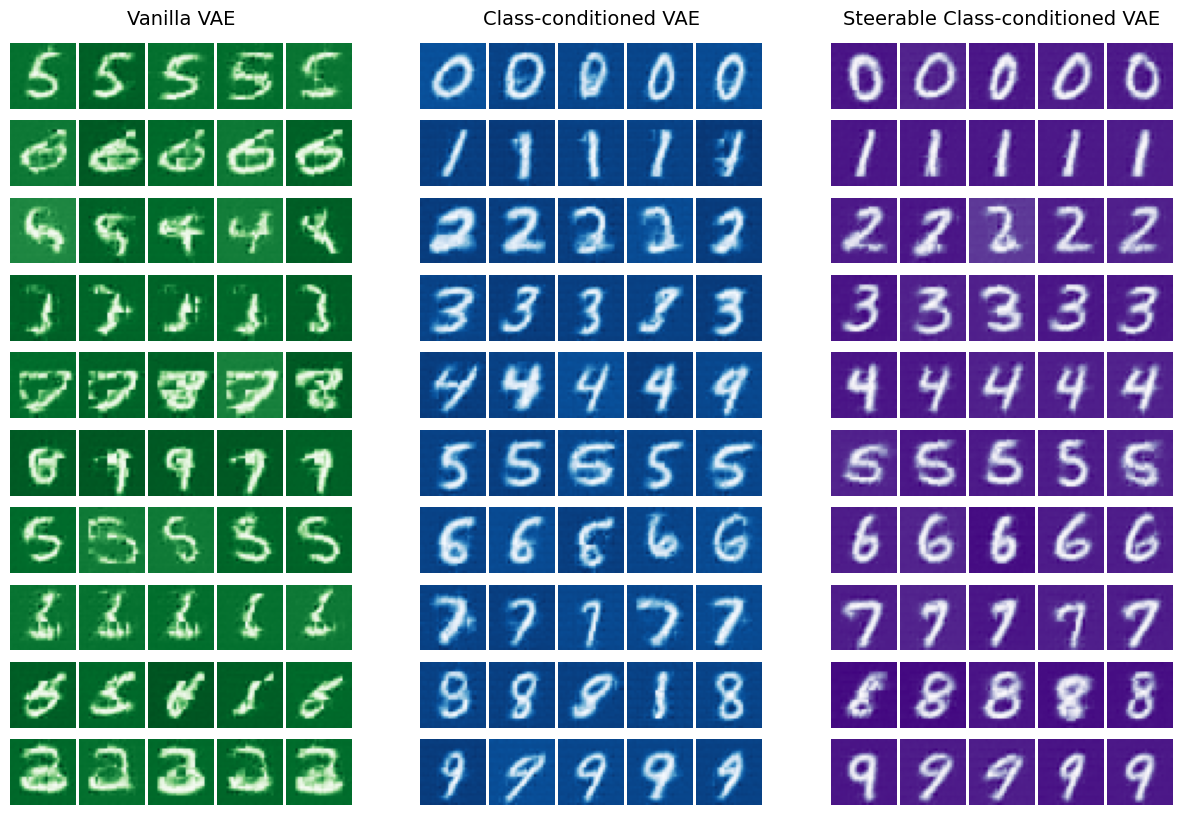

In [4]:
import matplotlib.pyplot as plt
import torch

def plot_generated(runner, n_samples_per_class, cmap, title, outer_spec, fig):
    n_classes = runner.model.num_classes
    n_samples = n_samples_per_class * n_classes
    latents = torch.randn(n_samples, runner.model.embed_dim, device=runner.device)
    labels = torch.arange(n_samples, device=runner.device) % n_classes
    generated_images = runner.model.decode(latents, runner.one_hot(labels))

    # Rows = classes, Cols = samples per class
    gs_inner = outer_spec.subgridspec(n_classes, n_samples_per_class, wspace=0.05, hspace=0.05)

    for i in range(n_samples):
        cls = labels[i].item()
        sample_idx = i // n_classes   # column index within that class row

        ax_sub = fig.add_subplot(gs_inner[cls, sample_idx])
        img = generated_images[i].detach().cpu().numpy().transpose(1, 2, 0)
        ax_sub.imshow(img, cmap=cmap)
        ax_sub.axis("off")

        # Label each row once
        if sample_idx == 0:
            ax_sub.set_ylabel(str(cls), fontsize=10, rotation=0, labelpad=15, va="center")

    # Title above the whole subgrid
    pos = outer_spec.get_position(fig)
    fig.text(
        (pos.x0 + pos.x1) / 2,
        pos.y1 + 0.01,
        title,
        ha="center", va="bottom", fontsize=14
    )

# Example usage
fig = plt.figure(figsize=(15, 10))
outer_gs = fig.add_gridspec(1, len(runners))

for i, runner_dict in enumerate(runners):
    runner = runner_dict["runner"]
    cmap = runner_dict["cmap"]
    title = runner_dict["title"]

    plot_generated(runner, 5, cmap, title, outer_gs[i], fig)  # 10 samples per class

# plt.tight_layout()
plt.savefig("model_generation.png", dpi=50)

/Users/jordanlei/Github/img-gen-transformer/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/jordanlei/Github/img-gen-transformer/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/jordanlei/Github/img-gen-transformer/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


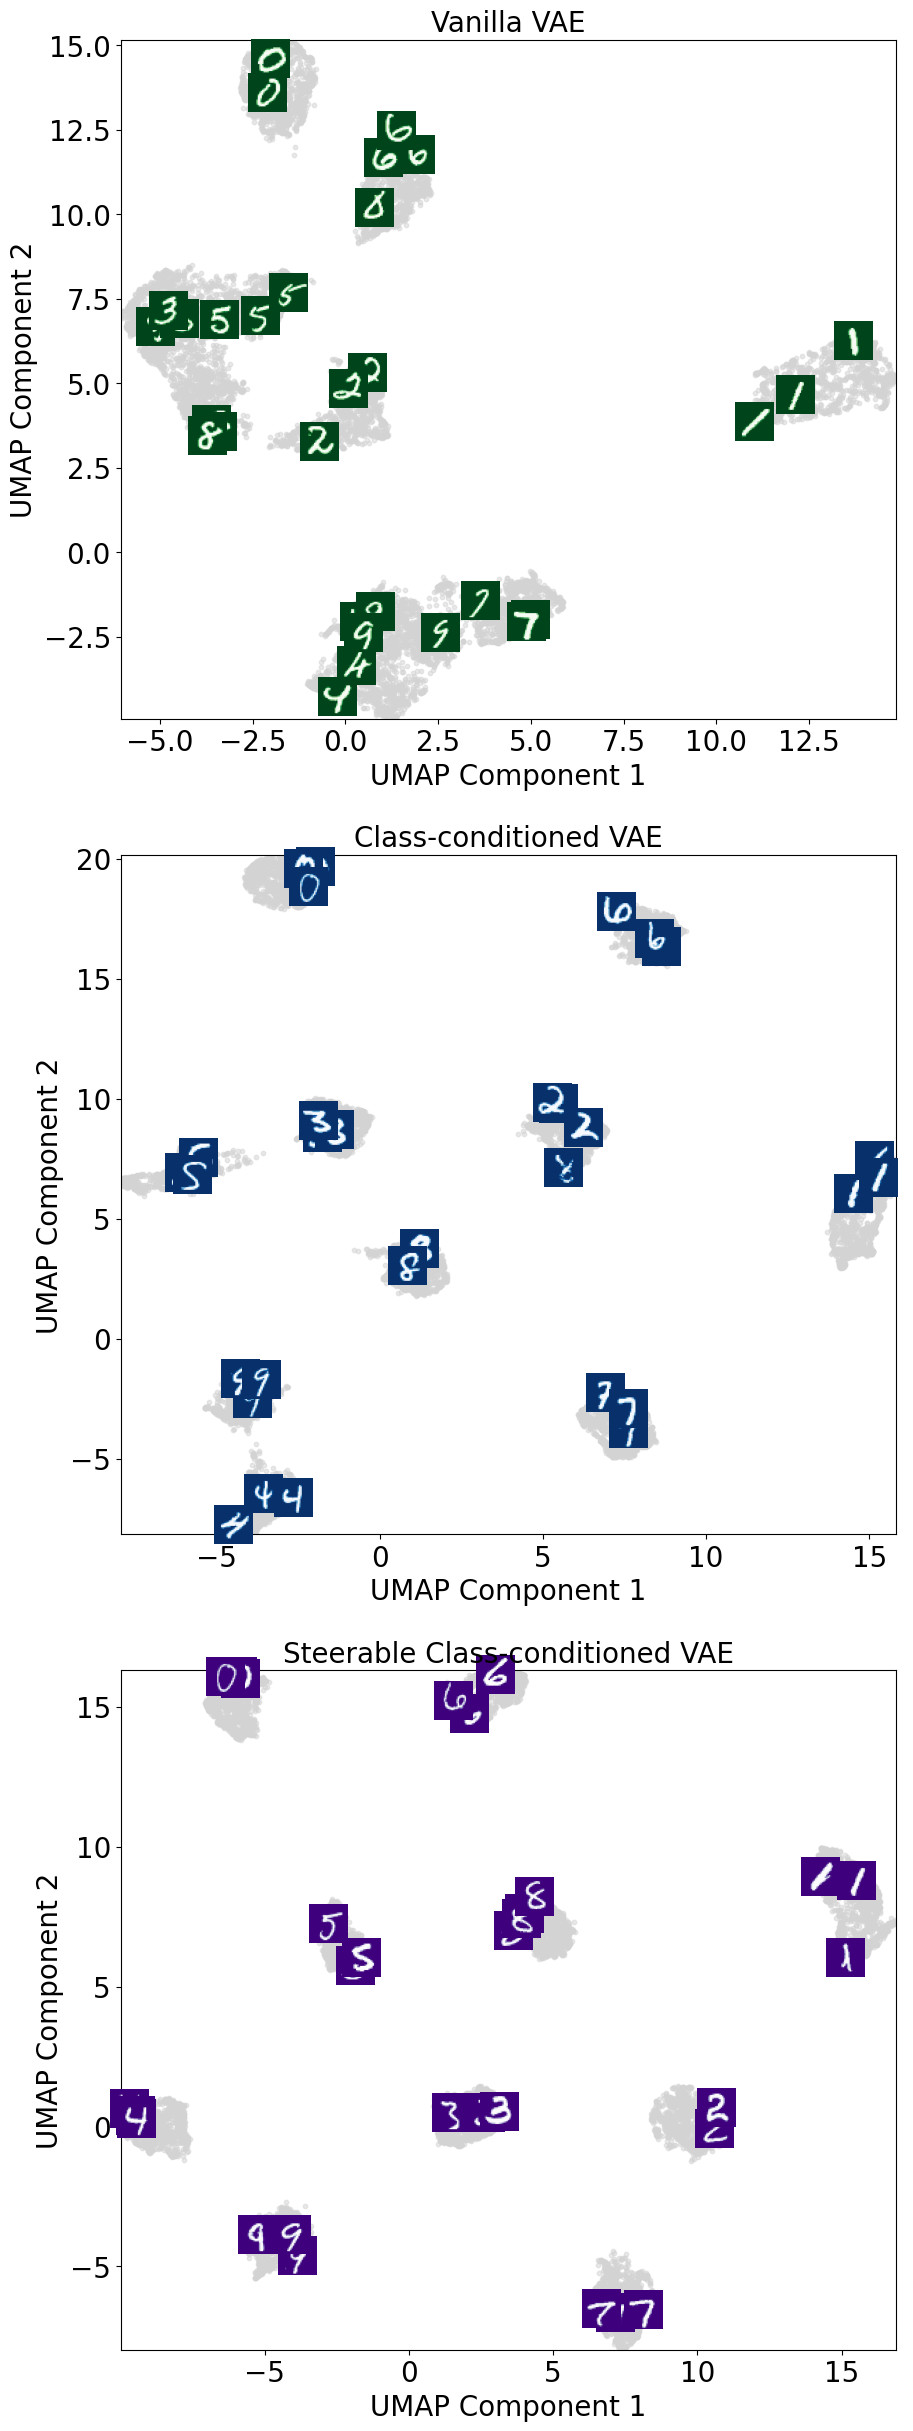

In [5]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
from umap import UMAP

def plot_umap(runner, cmap, title, ax = None):
    # Collect embeddings and labels from test set
    embeddings, xs, ys = [], [], []
    runner.model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(runner.device)
            y = y.to(runner.device)
            _, mu, logvar, cls_output = runner.model(x, None)
            embeddings.append(runner.model.encoder.embedded.cpu())
            xs.append(x.cpu())
            ys.append(y.cpu())

    # Concatenate batches
    embeddings = torch.cat(embeddings)
    xs = torch.cat(xs)
    ys = torch.cat(ys)

    # Reduce dimensionality with UMAP
    umap = UMAP(n_components=2, random_state=42)
    embeddings_2d = umap.fit_transform(embeddings.numpy())

    if not ax:
        fig, ax = plt.subplots(figsize=(10, 10))

    ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c='lightgray', alpha=0.5, s=10)

    # Set axis limits
    ax.set_xlim(embeddings_2d[:,0].min(), embeddings_2d[:,0].max())
    ax.set_ylim(embeddings_2d[:,1].min(), embeddings_2d[:,1].max())

    # Plot sample images for each class
    samples_per_class = 3
    for cls in range(10):
        mask = (ys == cls)
        # select the first samples_per_class points
        points = embeddings_2d[mask][:samples_per_class]
        images = xs[mask][:samples_per_class]
        
        # Add image thumbnails
        for point, img in zip(points, images):
            img = np.moveaxis(img.cpu().numpy(), 0, -1).squeeze(-1)
                
            # Create and add image annotation
            ab = AnnotationBbox(OffsetImage(img, zoom=1, cmap=cmap), (float(point[0]), float(point[1])), frameon=False, box_alignment=(0.5, 0.5))
            ax.add_artist(ab)

    # Add labels
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('UMAP Component 1', fontsize=20)
    ax.set_ylabel('UMAP Component 2', fontsize=20)
    


fig, ax = plt.subplots(len(runners), 1, figsize=(10, 30))

for i, runner_dict in enumerate(runners):
    runner = runner_dict["runner"]
    cmap = runner_dict["cmap"]
    title = runner_dict["title"]
    plot_umap(runner, cmap, title, ax = ax[i])

plt.savefig("model_embeddings.png", dpi=50)


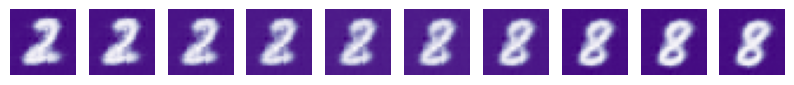

In [6]:
random_latent = torch.randn(1, runner.model.embed_dim, device=runner.device)

interp = torch.stack([alpha * runner.one_hot(8) + (1 - alpha) * runner.one_hot(2) for alpha in np.arange(0, 1, 0.1)])
repeated_latent = random_latent.repeat(interp.shape[0], 1)
generated_images = runner.model.decode(repeated_latent, interp)
fig, ax = plt.subplots(1, len(generated_images), figsize=(10, 2))
for i, img in enumerate(generated_images):
    ax[i].imshow(img.detach().cpu().numpy().transpose(1, 2, 0), cmap=cmap)
    ax[i].axis("off")

plt.savefig("generated_interp.png", dpi = 50)

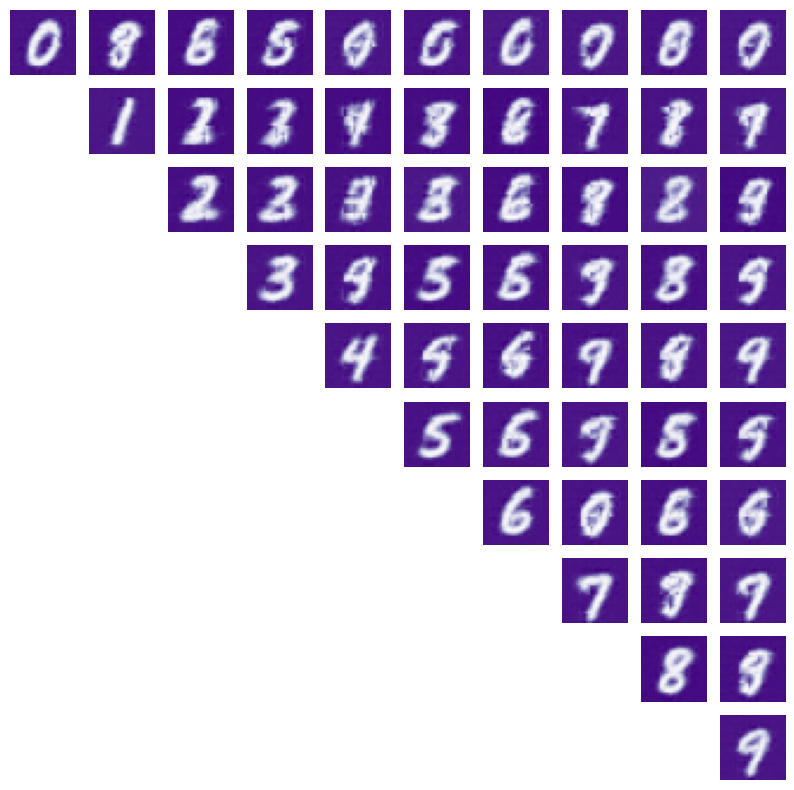

In [7]:
interp = torch.stack([0.5 * runner.one_hot(i) + 0.5 * runner.one_hot(j) for i in range(10) for j in range(10)])
repeated_latent = random_latent.repeat(interp.shape[0], 1)
generated_images = runner.model.decode(repeated_latent, interp)

fig, ax = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10): 
    for j in range(10): 
        if i < j + 1:
            ax[i, j].imshow(generated_images[i * 10 + j].detach().cpu().numpy().transpose(1, 2, 0), cmap=cmap)
        ax[i, j].axis("off")
plt.savefig("generated_interp_cross.png", dpi = 50)